In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import model_selection
# Show pipeline as plot
from sklearn import set_config
set_config(display='diagram')
import xgboost as xgb
import seaborn as sns
import math as math

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.head()

,Unnamed: 0,Unnamed: 0.1,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,...,Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy,age_group,age_category
0,0,0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy,40-50,adult
1,1,1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy,70-80,senior
2,2,2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy,70-80,senior
3,3,3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy,40-50,adult
4,4,4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy,60-70,senior


In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'CRC', 'Crohns disease', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(3153, 903)

In [7]:
ClinicalNumeric_vars = ['BMI (kg/m²)', 'FBG (mmol/L)', 'TRIG (mmol/L)', 'LDLC (mmol/L)','CHOL (mmol/L)', 'HDLC (mmol/L)']
# ClinicalNumeric_vars = ['BMI (kg/m²)']
ClinicalData_numeric = SampleMeta[ClinicalNumeric_vars]
ClinicalData_numeric.rename(columns={'BMI (kg/m²)':'BMI', 'FBG (mmol/L)':'FBG', 'TRIG (mmol/L)':'TRIG', 'LDLC (mmol/L)':'LDLC','CHOL (mmol/L)':'CHOL', 'HDLC (mmol/L)':'HDLC'}, inplace=True)
# Manipulate and convert to float
ClinicalData_numeric["BMI"].replace({'not recorded':np.nan, '<23':'22.99', 'Mismatch for Sample ID':np.nan, '<25':'24.99'}, inplace=True)
ClinicalData_numeric["BMI"].astype(float)
ClinicalData_numeric["FBG"].astype(float)
ClinicalData_numeric["TRIG"].astype(float)
ClinicalData_numeric["LDLC"].astype(float)
ClinicalData_numeric["HDLC"].astype(float)
ClinicalData_numeric = ClinicalData_numeric.fillna(-99)
ClinicalNumeric_vars = ClinicalData_numeric.columns.tolist()
ClinicalCategorical_vars = ['Gender', 'Geographical Region or Population','Physical Exercise (Yes/No/Hours)','Smoking (Yes/No)', 
                            'Residence (Rural/Urban)','Use of milk or milk products (Yes/No/Sometimes)',
                            'Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan)','Alcohol Consumption (Yes/No)', 
                            'Diet1','Intervention for study (Diet)', 'Intervention for study (medication)', 'age_category']
# ClinicalCategorical_vars = ['Gender', 'Geographical Region or Population','Physical Exercise (Yes/No/Hours)','Smoking (Yes/No)', 
#                             'Residence (Rural/Urban)','Use of milk or milk products (Yes/No/Sometimes)',
#                             'Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan)','Alcohol Consumption (Yes/No)', 
#                             'Diet1','Intervention for study (Diet)', 'Intervention for study (medication)', 'age_category']
# ClinicalCategorical_vars = ['Gender', 'age_category']
ClinicalData_categorical = SampleMeta[ClinicalCategorical_vars]
ClinicalData_categorical.rename(columns={'Geographical Region or Population':'GRoP', 
                                         'Physical Exercise (Yes/No/Hours)':'Phys_Ex', 
                                         'Smoking (Yes/No)':'Smoking',
                                         'Residence (Rural/Urban)':'Residence',
                                         'Use of milk or milk products (Yes/No/Sometimes)':'milk',
                                         'Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan)':'meat',
                                         'Alcohol Consumption (Yes/No)':'alcohol',
                                         'Intervention for study (Diet)':'Diet2', 
                                         'Intervention for study (medication)':'medication'}, inplace=True)
# Manipulate and make data consistant..
ClinicalData_categorical["Gender"].replace({'not recorded':np.nan, 'Mismatch for Sample ID':np.nan, 'female':'F', 'male':'M'}, inplace=True)
## Replace NaN with string missing
ClinicalData_categorical = ClinicalData_categorical.fillna("missing")
ClinicalCategorical_vars = ClinicalData_categorical.columns.tolist()

In [8]:
cat_sizes = {}
cat_embsizes = {}
for cat_var in ClinicalCategorical_vars:
    cat_sizes[cat_var] = ClinicalData_categorical[cat_var].nunique()
    cat_embsizes[cat_var] = min(50, cat_sizes[cat_var]//2+1)
print( f"cat_sizes={cat_sizes}\ncat_embsizes={cat_embsizes}" )

cat_sizes={'Gender': 3, 'GRoP': 31, 'Phys_Ex': 7, 'Smoking': 5, 'Residence': 3, 'milk': 2, 'meat': 4, 'alcohol': 6, 'Diet1': 6, 'Diet2': 2, 'medication': 2, 'age_category': 5}
cat_embsizes={'Gender': 2, 'GRoP': 16, 'Phys_Ex': 4, 'Smoking': 3, 'Residence': 2, 'milk': 2, 'meat': 3, 'alcohol': 4, 'Diet1': 4, 'Diet2': 2, 'medication': 2, 'age_category': 3}


In [9]:
from sklearn.preprocessing import OrdinalEncoder
clin_data_arrays = []
for cat_var in ClinicalCategorical_vars:
    ohe = OrdinalEncoder()
    ohe.fit(ClinicalData_categorical[cat_var].to_numpy().reshape(-1, 1))
    clin_data_arrays.append( ohe.transform( ClinicalData_categorical[cat_var].to_numpy().reshape(-1, 1) ) )    

In [10]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Define and Train Model

In [17]:
# random seed here deals with model initialization
clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", gamma=5, subsample=0.5, max_delta_step=1, scale_pos_weight=math.sqrt(1721
/328))
param_grid = {'eta': [0.3],
             'max_depth': [6]}
model = model_selection.GridSearchCV(clf, param_grid, scoring = metrics.make_scorer(metrics.balanced_accuracy_score), cv = 5)
MyTrainer = Trainer(model = model, scale_X = True, use_pca = False)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, metrics.balanced_accuracy_score, test_frac=0.35)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [18]:
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

In [19]:
data = np.hstack((MatrixData, ClinicalData_numeric.to_numpy(), np.hstack(clin_data_arrays)))
MyMultiTrainTester.train(data, y)

Running for split 1 of 5
Using predict_proba
getting predictions from probs
Running for split 2 of 5
Using predict_proba
getting predictions from probs
Running for split 3 of 5
Using predict_proba
getting predictions from probs
Running for split 4 of 5
Using predict_proba
getting predictions from probs
Running for split 5 of 5
Using predict_proba
getting predictions from probs


In [20]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.992841,train
1,0.993451,train
2,0.992255,train
3,0.994528,train
4,0.994269,train
0,0.919831,test
1,0.940620,test
2,0.919965,test
3,0.925983,test
4,0.923689,test


<AxesSubplot:xlabel='stage', ylabel='score'>

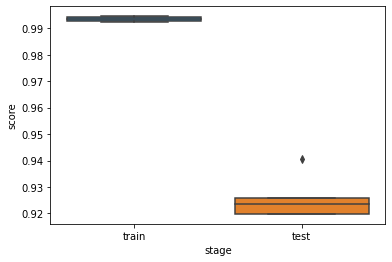

In [21]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [22]:
FinalModel = MyMultiTrainTester.TrainerList[0]

In [23]:
FinalModel.model

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=5,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=1,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=2.2906224524159793,
                                     subsample=0.5, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             param_grid={'eta': [0.3], 'max_depth': [6]},
             scoring=make_scorer(balanced_accuracy_score))

In [24]:
FinalModel.model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3,
              eval_metric='logloss', gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.2906224524159793, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
features = [FeatMeta.feature.to_list() + ClinicalData_numeric.columns.to_list() + ClinicalData_categorical.columns.to_list()]

In [44]:
feat_importances = pd.DataFrame(FinalModel.model.best_estimator_.feature_importances_, index=features, columns=["Importance"])
feat_importances.sort_values(["Importance"], ascending=False, inplace=True)

<AxesSubplot:ylabel='Frequency'>

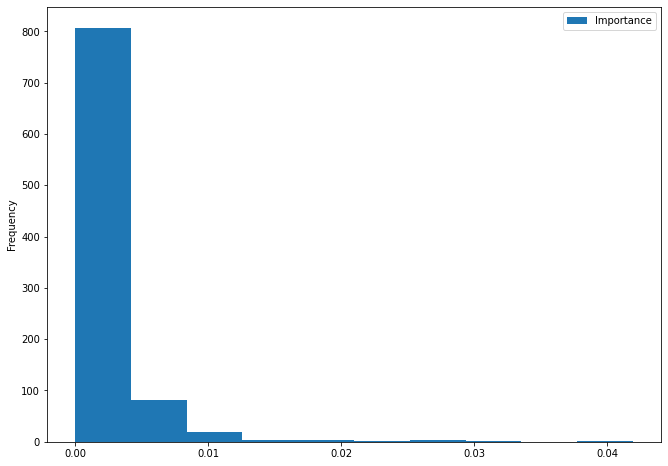

In [45]:
feat_importances.plot(kind="hist", figsize=(11, 8))

<AxesSubplot:>

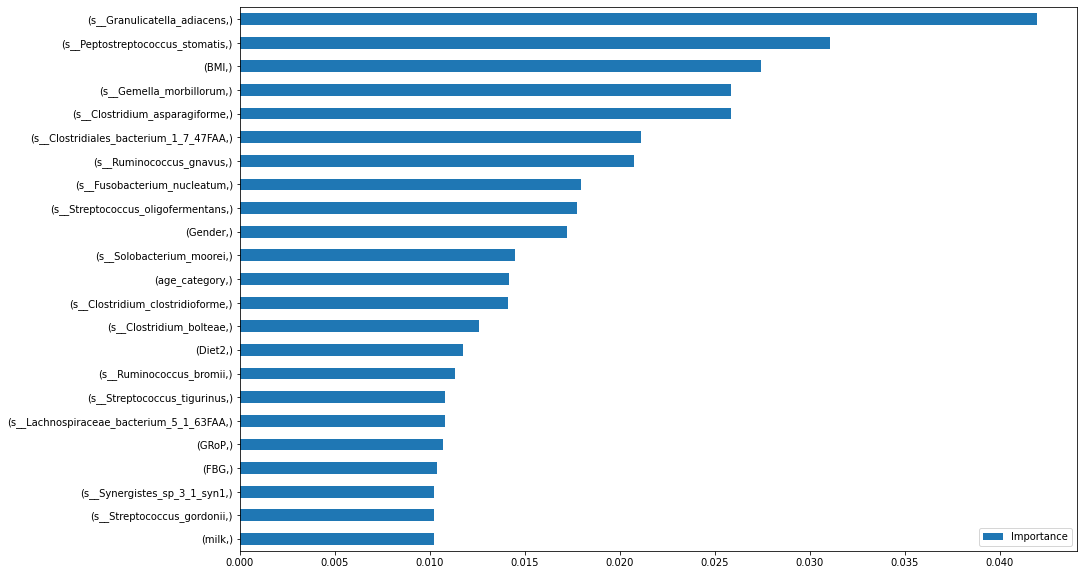

In [46]:
feat_importances = feat_importances[feat_importances>0.01].dropna()
feat_importances.sort_values(["Importance"], ascending=True).plot(kind='barh', figsize=(15,10))

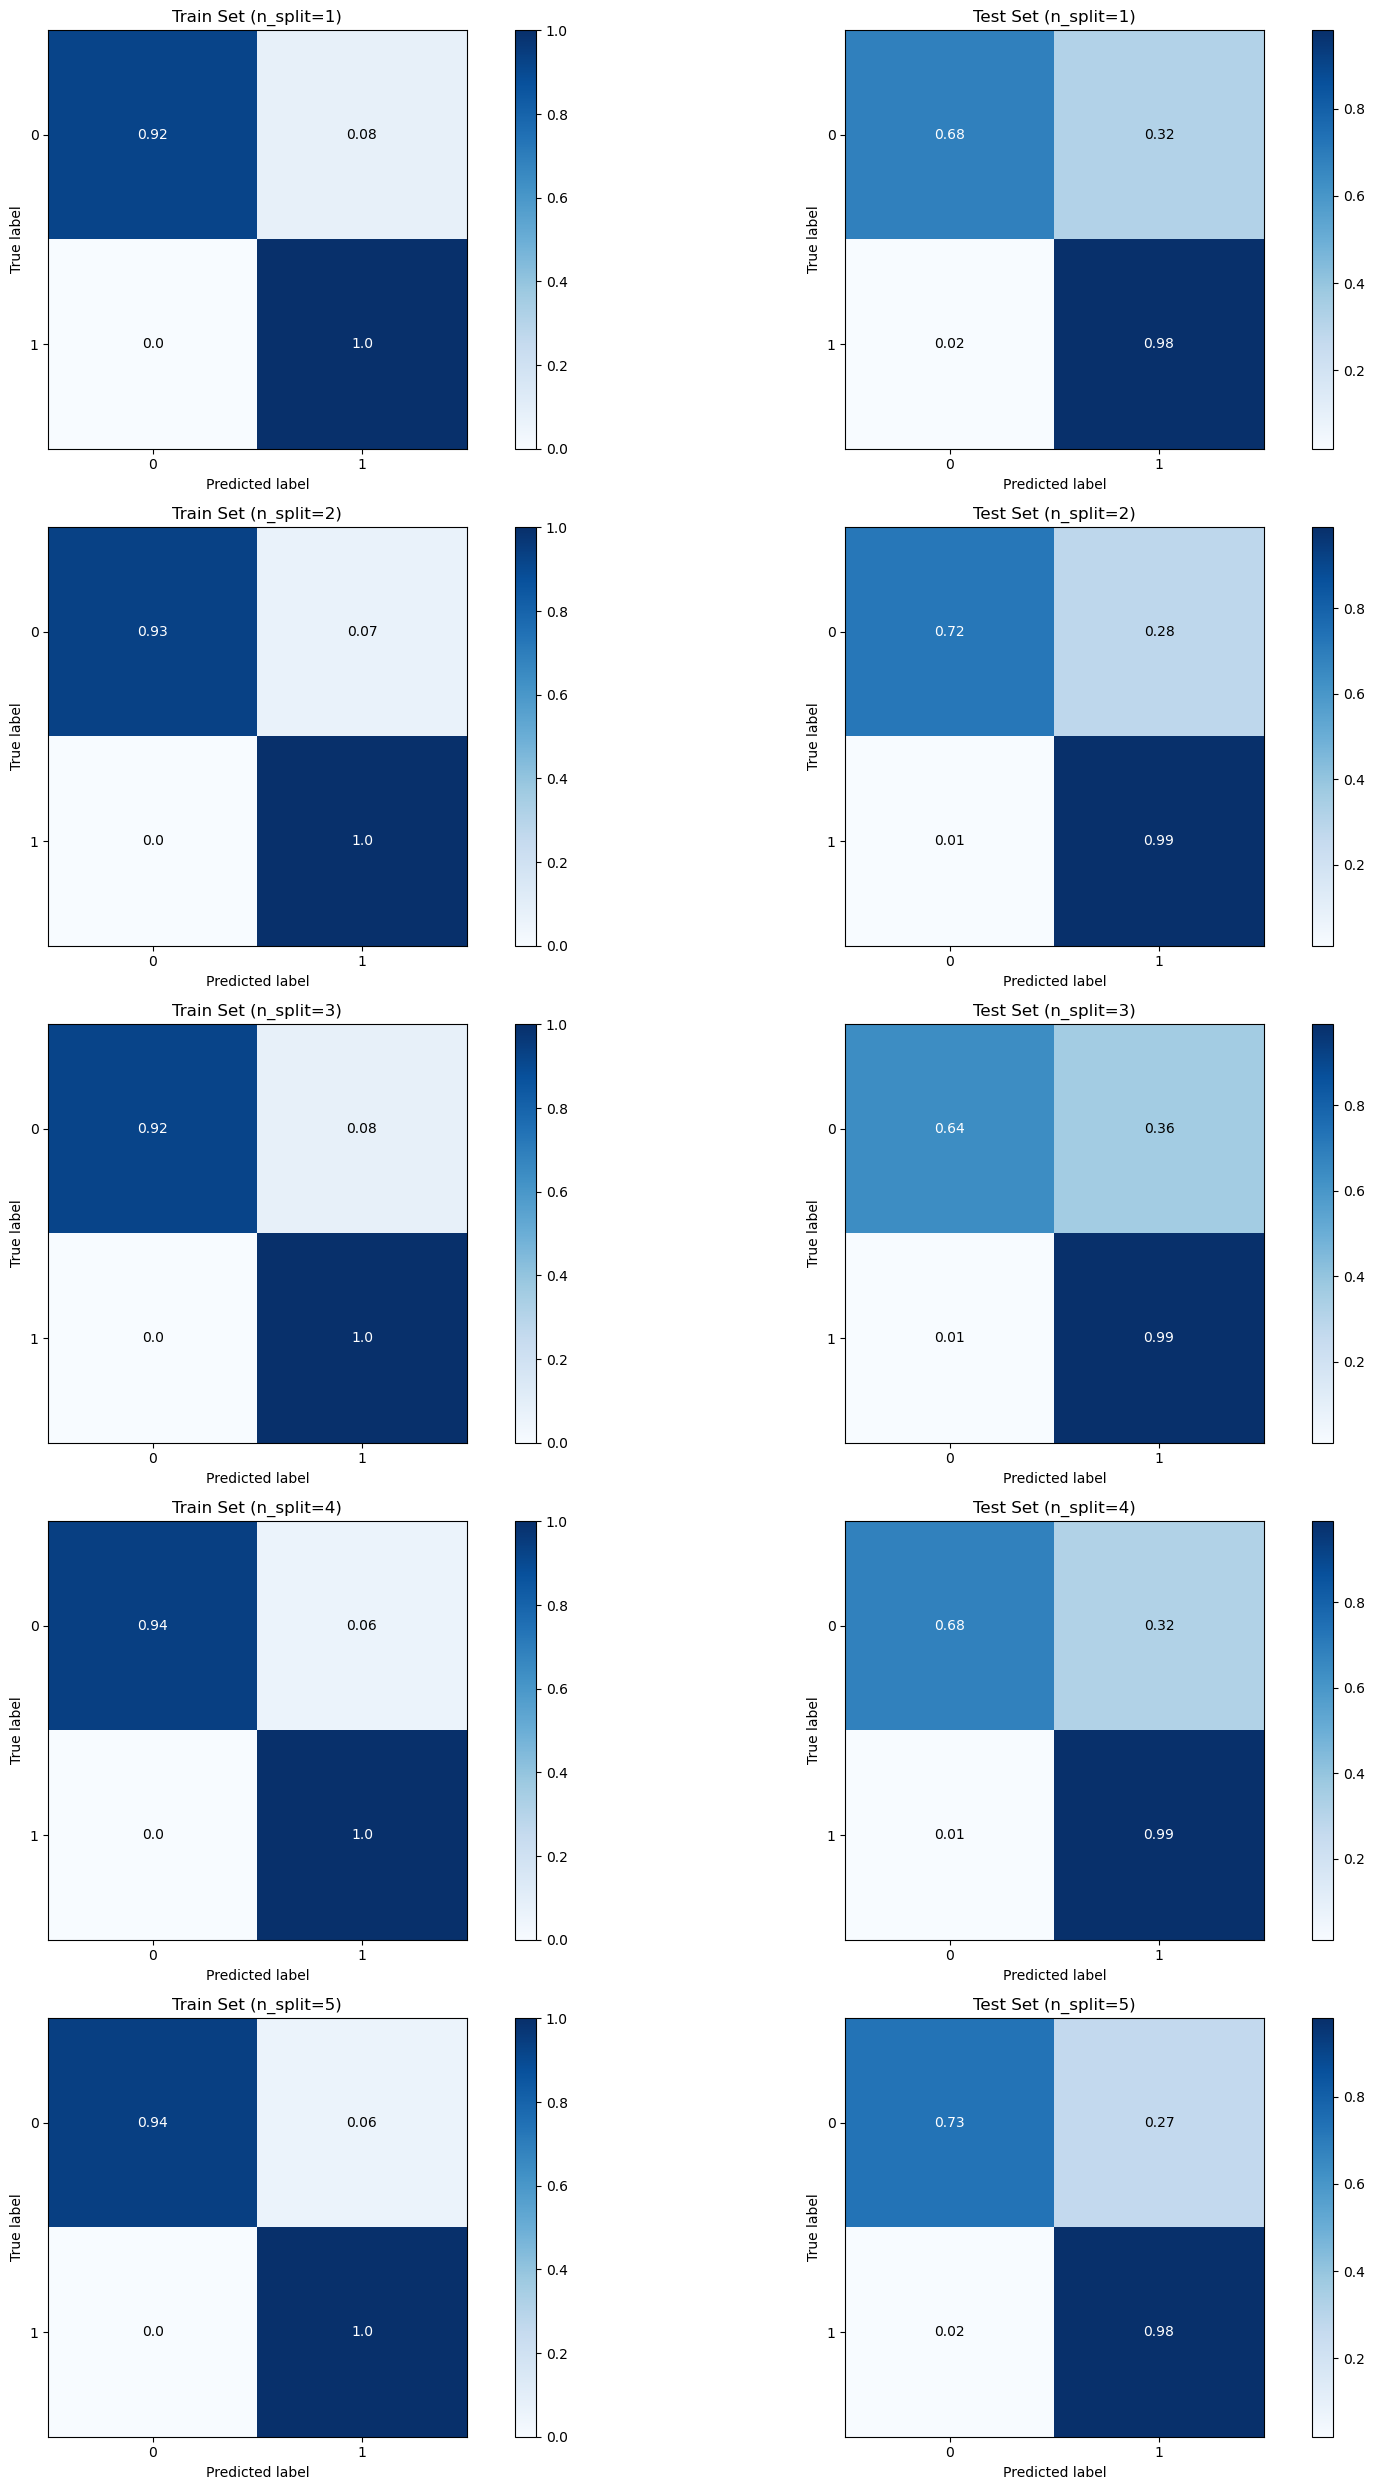

In [26]:
MyMultiTrainTester.plot_confusion(normalize=True)

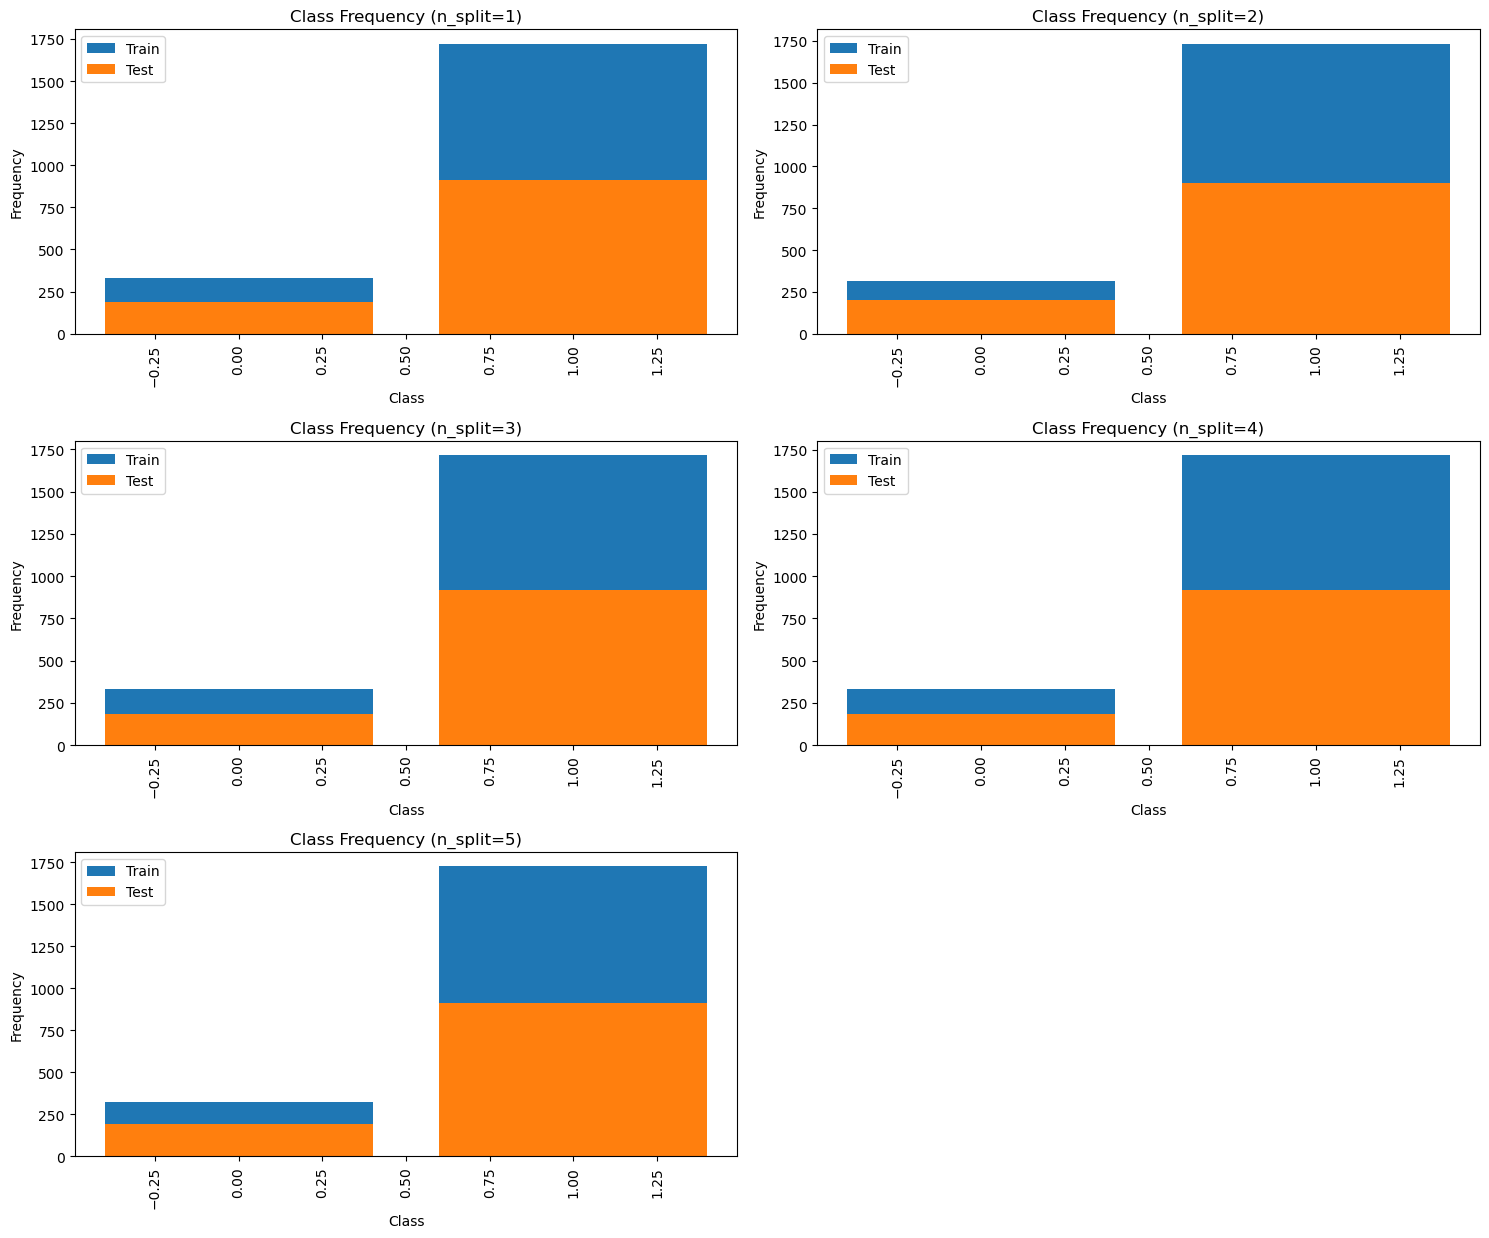

In [118]:
MyMultiTrainTester.plot_class_freq(normalize=True)

In [53]:
cat_embsizes


{'Gender': 2,
 'GRoP': 16,
 'Phys_Ex': 4,
 'Smoking': 3,
 'Residence': 2,
 'milk': 2,
 'meat': 3,
 'alcohol': 4,
 'Diet1': 4,
 'Diet2': 2,
 'medication': 2,
 'age_category': 3}

In [27]:
pd.value_counts(MyMultiTrainTester.y_train[0])

1    1721
0     328
dtype: int64

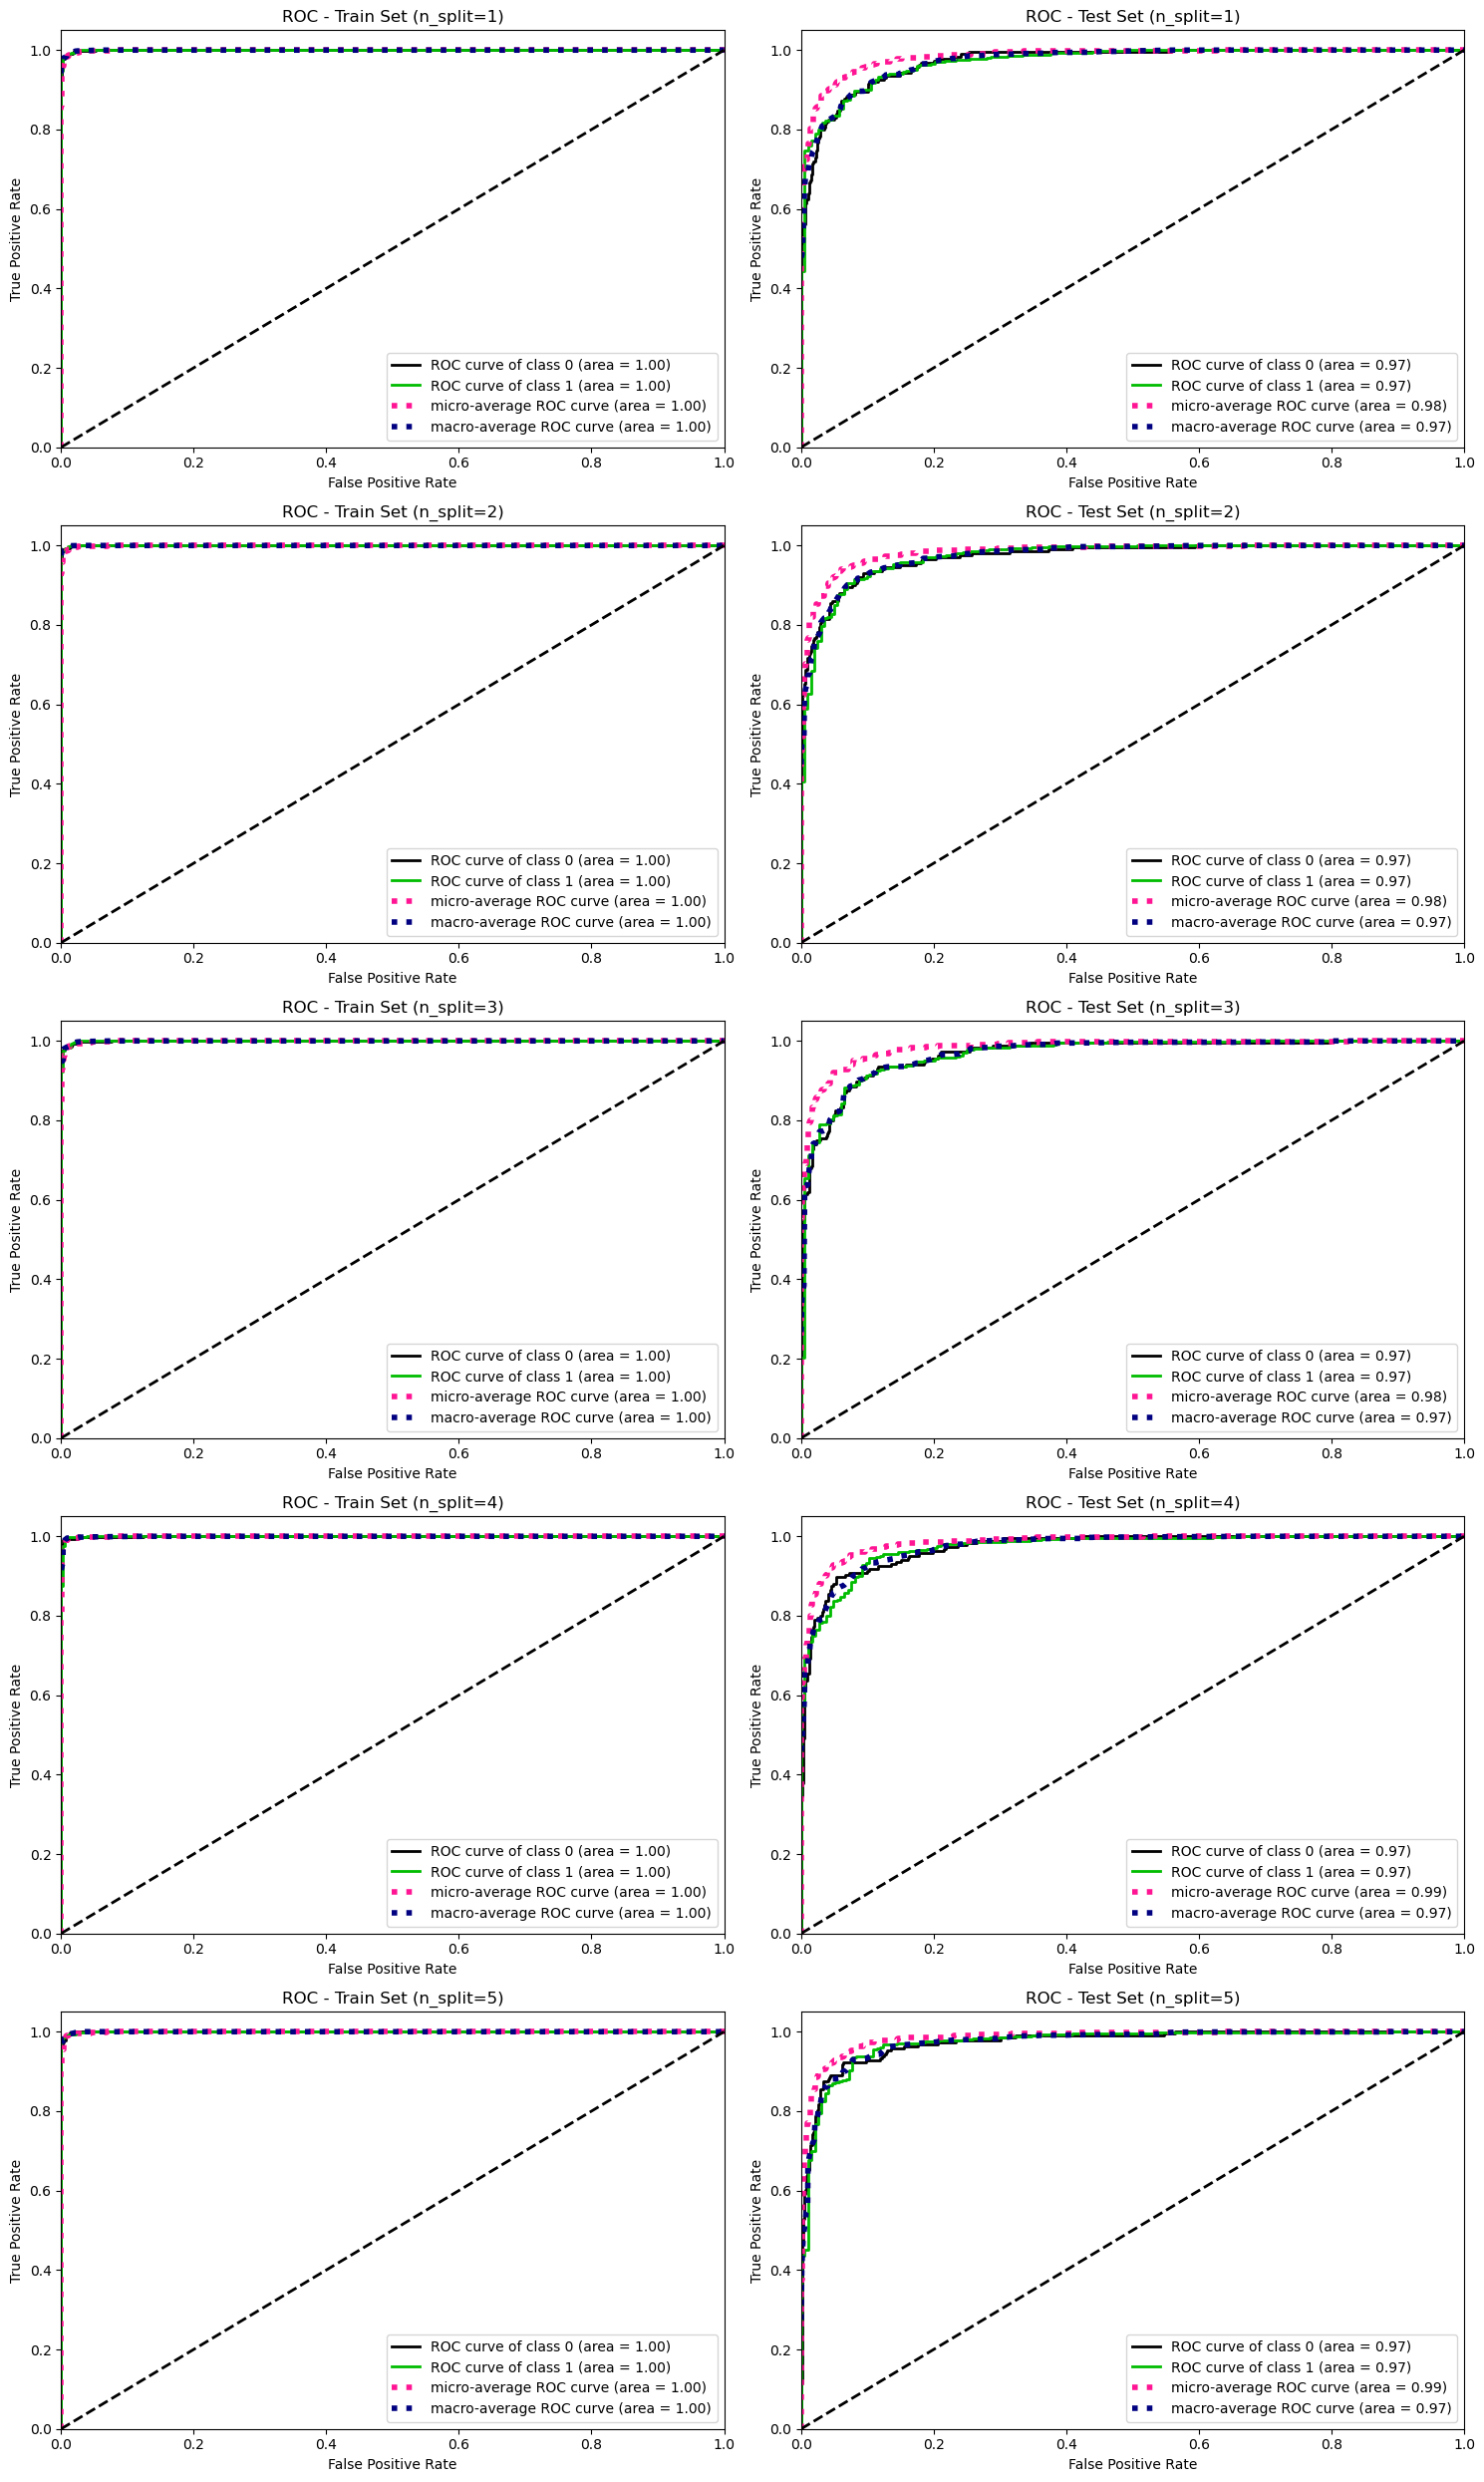

In [28]:
MyMultiTrainTester.plot_roc(figsize=(15, 25))

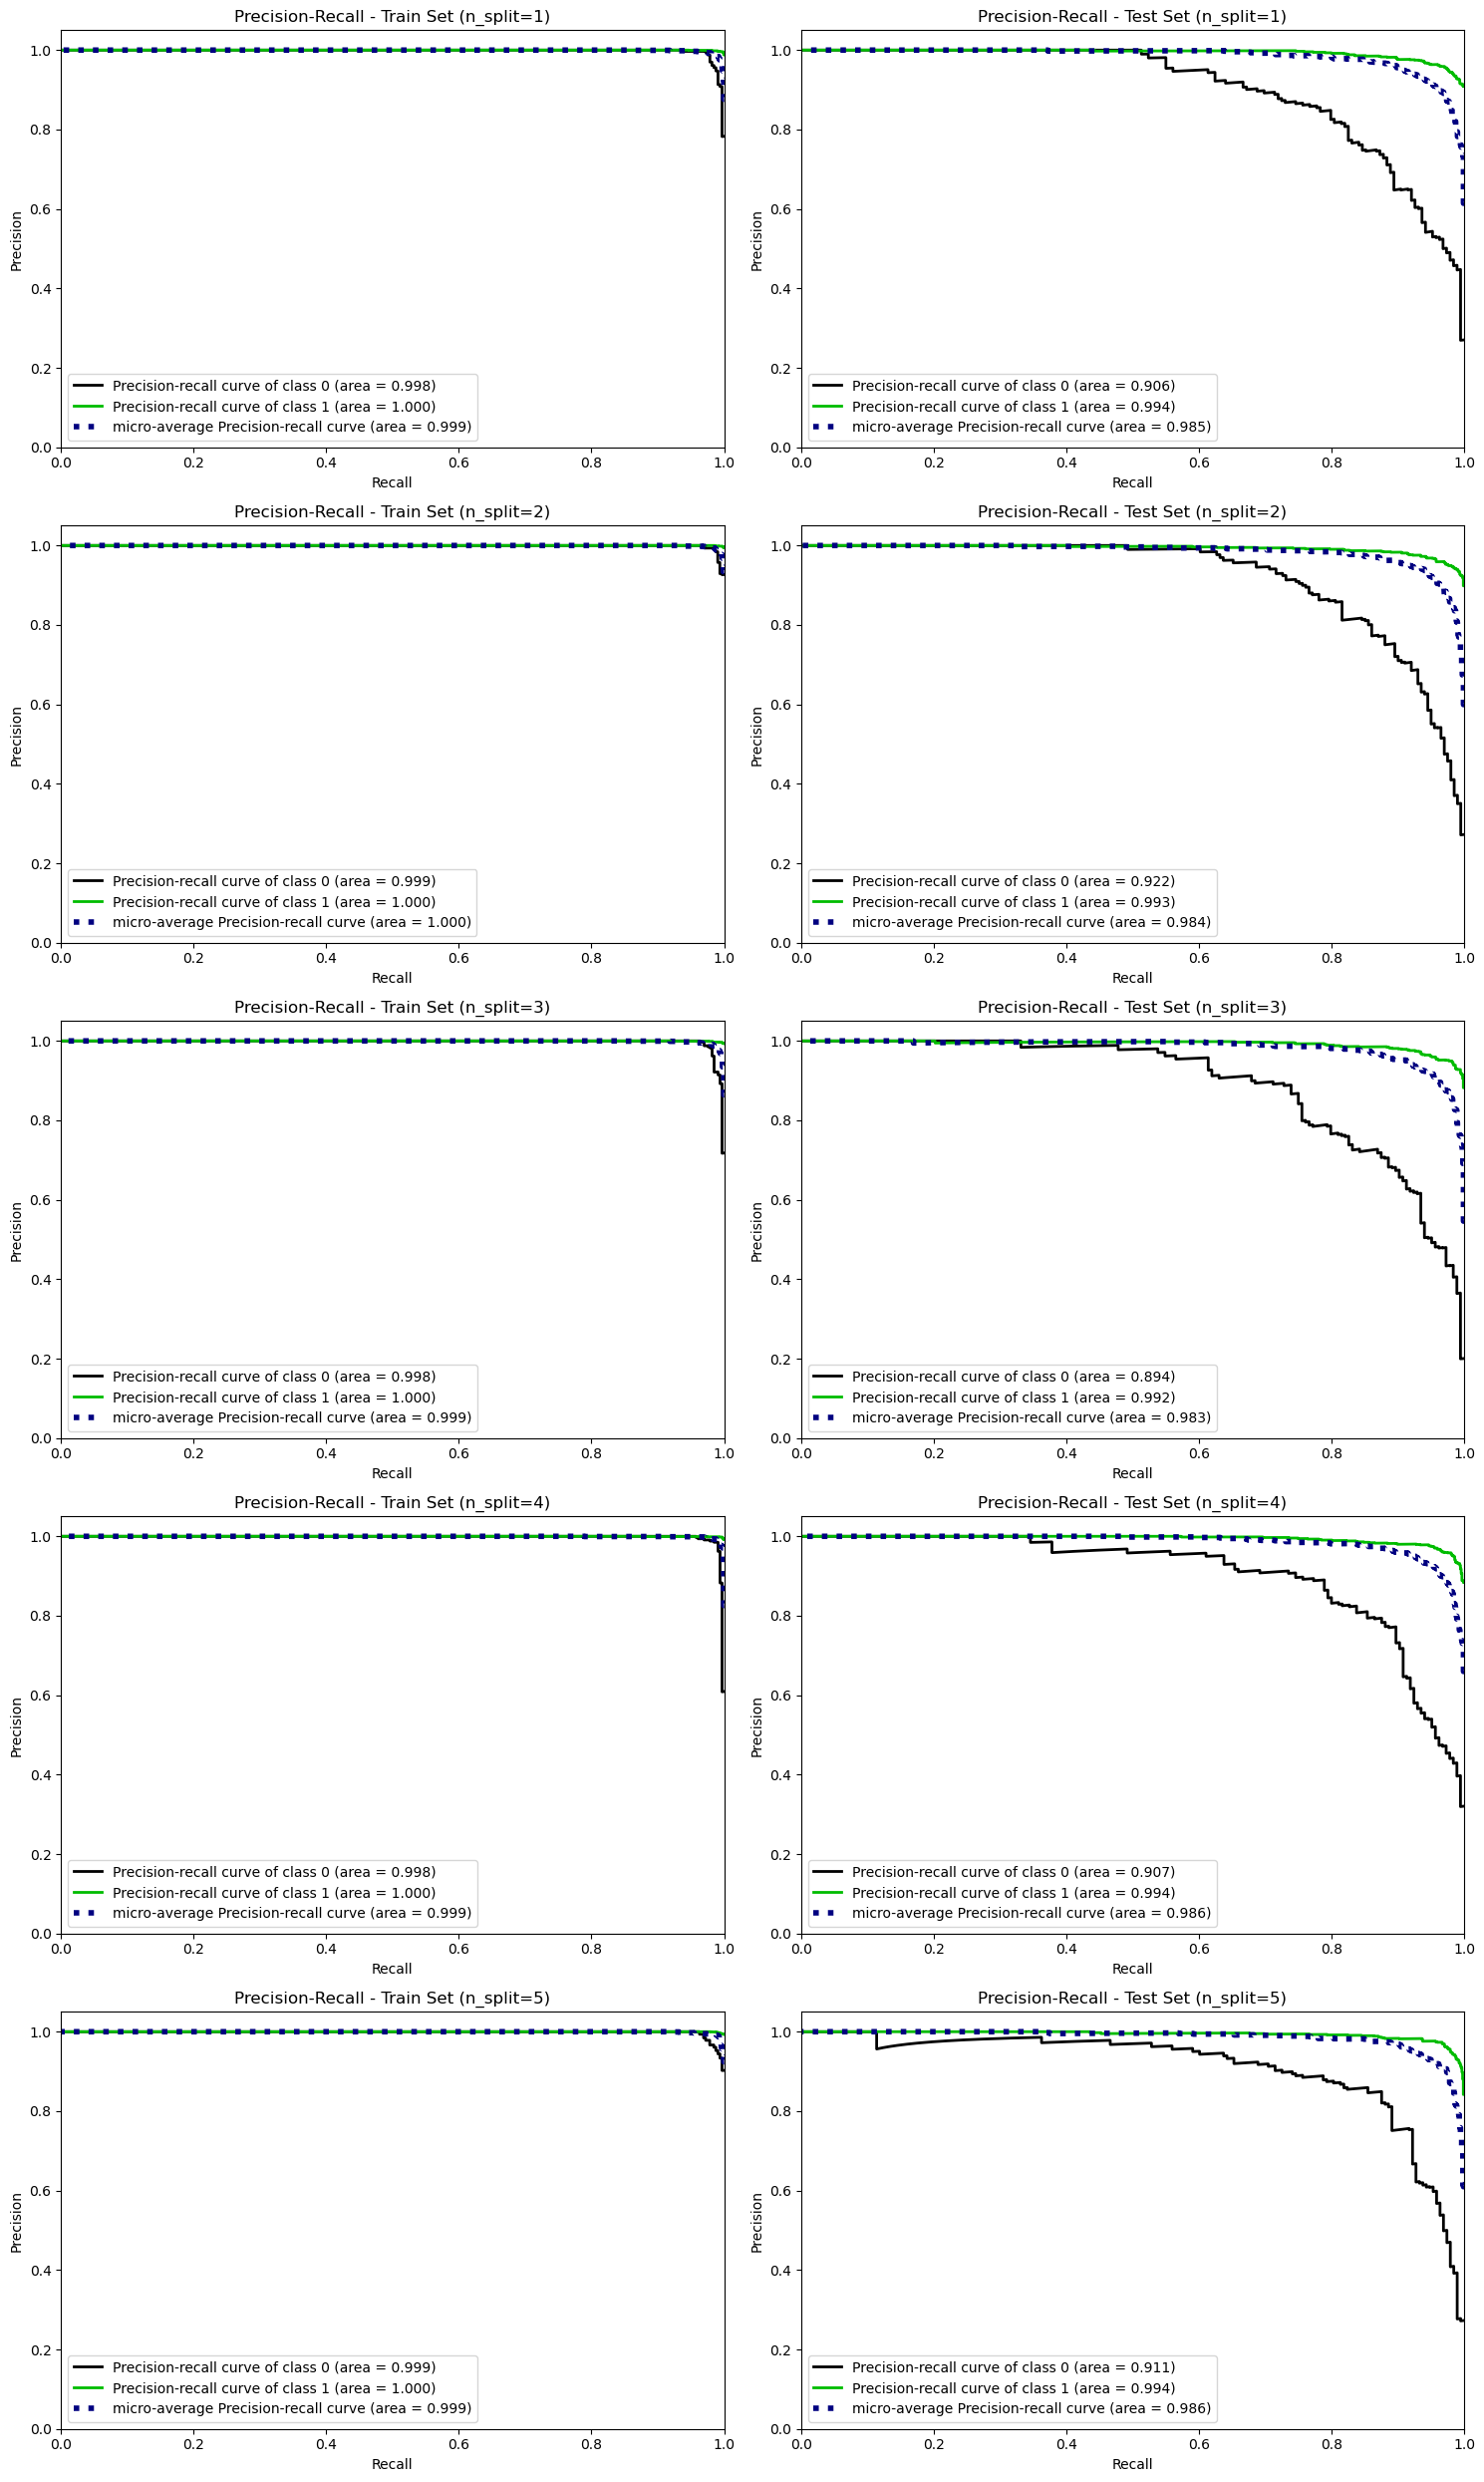

In [49]:
MyMultiTrainTester.plot_precrecall(figsize=(15, 25))